In [75]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression

import xgboost as xgb
from scipy.stats import uniform, randint

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor
random_state = 42


## Data description

The dataset for this project is a subset taken from a clinical thermographic imaging study. It contains a set of thermal reading done with a FLIR infrared thermograph along with some contextual features for the subject, which will be described below. We choose to only include the first round of measurments to keep in line with a more realistic setting where the temperature would not be checked four times, however we do recognize that all rounds could be kept in favour of achieving better results. Group 1 and Group 2 denoted different ambient temperatures and both and included simuntenoulsy to evaluate the impact of said temperature on the accuracy of predictions. The idea for this project is to predict the temperature measured by an actual oral thermometer set to monitor mode (a more accurate mode), using thermograph readings and context. Therefore the target variable is *aveOralM*, the only excluded variables were the *SubjectID*, *aveOralF*, *Date*, and *Time* which had no relevance. The tables below are copied from the article.

Table 1. Description of thermal features
| Names       | Names in papers [2,3] | Regions of interest                                                                                                                                                   | Value calculation                                                               |
| ----------- | --------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| Max1R13_*   | TCRmax                | A circle with diameter of 13 pixels from the right canthus point to the face centerline                                                                               | Maximum temperature within the circle                                           |
| Max1L13_*   | TCLmax                | A circle with diameter of 13 pixels from the left canthus point to the face centerline                                                                                | Maximum temperature within the circle                                           |
| aveAllR13_* | T̄CR                  | A circle with diameter of 13 pixels from the right canthus point to the face centerline                                                                               | Average temperature within the whole circle                                     |
| aveAllL13_* | T̄CL                  | A circle with diameter of 13 pixels from the left canthus point to the face centerline                                                                                | Average temperature within the whole circle                                     |
| T_RC*       |                       | A square of 24×24 pixels around the right canthus, with 2/3 toward the face center (dry area, 16×24 pixels) and 1/3 away from the face center (wet area, 8×24 pixels) | Average temperature of the highest four pixels                                  |
| T_RC_Dry*   |                       | The right canthus dry area, a rectangle of 16×24 pixels                                                                                                               | Average temperature of the highest four pixels                                  |
| T_RC_Wet*   |                       | The right canthus wet area, a rectangle of 8×24 pixels                                                                                                                | Average temperature of the highest four pixels                                  |
| T_RC_Max*   |                       | A square of 24×24 pixels around the right canthus, with 2/3 toward the face center (dry area, 16×24 pixels) and 1/3 away from the face center (wet area, 8×24 pixels) | Maximum temperature within the square                                           |
| T_LC*       |                       | A square of 24×24 pixels around the left canthus, with 2/3 toward the face center (dry area, 16×24 pixels) and 1/3 away from the face center (wet area, 8×24 pixels)  | Average temperature of the highest four pixels                                  |
| T_LC_Dry*   |                       | The left canthus dry area, a rectangle of 16×24 pixels                                                                                                                | Average temperature of the highest four pixels                                  |
| T_LC_Wet*   |                       | The left canthus wet area, a rectangle of 16×24 pixels                                                                                                                | Average temperature of the highest four pixels                                  |
| T_LC_Max*   |                       | A square of 24×24 pixels around the left canthus, with 2/3 toward the face center (dry area, 16×24 pixels) and 1/3 away from the face center (wet area, 8×24 pixels)  | Maximum temperature within the square                                           |
| RCC*        |                       | A square of 3×3 pixels centered at the right canthus point                                                                                                            | Average temperature within the square                                           |
| LCC*        |                       | A square of 3×3 pixels centered at the left canthus point                                                                                                             | Average temperature within the square                                           |
| canthiMax*  | TCEmax                | Extended canthi area, see definition in papers [1,2]                                                                                                                  | Maximum temperature within the extended canthus area                            |
| canthi4Max* |                       | Extended canthi area, see definition in papers [1,2]                                                                                                                  | Average temperature of the highest four pixels within the extended canthus area |
| T_FHCC*     | TFC                   | Center point of forehead, a square of 3×3 pixels                                                                                                                      | Average temperature within the square                                           |
| T_FHRC*     | TFR                   | Right point of the forehead, a square of 3×3 pixels                                                                                                                   | Average temperature within the square                                           |
| T_FHLC*     | TFL                   | Left point of the forehead, a square of 3×3 pixels                                                                                                                    | Average temperature within the square                                           |
| T_FHBC*     | TFB                   | Bottom point of the forehead, a square of 3×3 pixels                                                                                                                  | Average temperature within the square                                           |
| T_FHTC*     | TFT                   | Top point of the forehead, a square of 3×3 pixels                                                                                                                     | Average temperature within the square                                           |
| T_FH_Max*   | TFEmax                | Extended forehead area, see definition in papers [1,2]                                                                                                                | Maximum temperature within the extended forehead area                           |
| T_FHC_Max*  | TFCmax                | Center point of forehead, a square of 3×3 pixels                                                                                                                      | Maximum temperature within the square                                           |
| T_Max*      | Tmax                  | Whole face region, see definition in papers [1,2]                                                                                                                     | Maximum temperature within the whole face region                                |
| T_OR*       |                       | Oral/mouth region, see definition in papers [1,2]                                                                                                                     | Average temperature of the highest four pixels within the mouth region          |
| T_OR_Max*   |                       | Oral/mouth region, see definition in papers [1,2]                                                                                                                     | Maximum temperature within the mouth region                                     |

Table 2. Description of centextual features
| Names          | Definitions                                                                                                                                       |
| -------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| T_offset1 (°C) | Temperature difference between the set and measured blackbody temperature (see section 2.3.1 in the linked paper referenced in the table).        |
| aveOralF (°C)  | Average oral temperature measured twice with the oral thermometer under fast mode                                                           |
| aveOralM (°C)  | Average oral temperature measured twice with the oral thermometer under monitor mode                                                         |
| Gender         | Male or female                                                                                                                                    |
| Age            | Age range of the subjects                                                                                                                         |
| Ethnicity      | American Indian or Alaska Native; Asian; Black or African America; Hispanic/Latino; Multiracial; Native Hawaiian or other Pacific Islander; white |
| T_atm (°C)     | Ambient temperature                                                                                                                               |
| Humidity (%)   | Relative humidity                                                                                                                                 |
| Distance (m)   | Distance between the subjects and the IRTs                                                                                                        |
| Cosmetics      | “1” = cosmetics applied; “0” = no cosmetics applied (self-reported)                                                                               |
| Time           | Time when the data were collected                                                                                                                 |
| Date           | Date when the data were collected                                                                                                                 |

Source: https://physionet.org/content/face-oral-temp-data/1.0.0/

## EDA



In [76]:
raw = pd.read_csv("facial-and-oral-temperature-data-from-a-large-set-of-human-subject-volunteers-1.0.0\\FLIR_groups1and2.csv", header=None)

# The dataset uses row 2 as the header and row 3 onward as data.
df = raw.iloc[3:].copy()
df.columns = raw.iloc[2].tolist()
df = df.reset_index(drop=True)

# Drop separator / blank columns (NaN or empty header cells)
df = df.loc[:, [c for c in df.columns if isinstance(c, str) and c.strip() != ""]]

print("Loaded df:", df.shape)
df.head()


Loaded df: (1020, 120)


,SubjectID,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,...,aveOralM,Gender,Age,Ethnicity,T_atm,Humidity,Distance,Cosmetics,Time,Date
0,161117-1,0.58,34.98,35.36,34.44,34.85,34.91,34.91,34.60,34.98,...,36.59,Male,41-50,White,24,28,0.8,NaN,12:43:46,16-11-17
1,161117-2,0.83,34.71,34.51,34.46,34.24,34.68,34.68,34.44,34.71,...,37.19,Female,31-40,Black or African-American,24,26,0.8,NaN,15:22:48,16-11-17
2,161117-3,0.85,35.70,35.44,35.00,34.78,35.67,35.67,35.46,35.70,...,37.34,Female,21-30,White,24,26,0.8,NaN,15:52:56,16-11-17
3,161117-4,0.90,35.17,35.50,34.25,35.00,35.14,35.14,35.08,35.17,...,37.09,Female,21-30,Black or African-American,24,27,0.8,NaN,16:07:53,16-11-17
4,161117-5,1.08,35.33,35.55,34.31,35.14,35.50,35.30,35.50,35.52,...,37.04,Male,18-20,White,24,27,0.8,NaN,16:28:06,16-11-17


In [77]:
null_counts = df.isnull().sum()
print(null_counts.to_string())

SubjectID       0
T_offset1      17
Max1R13_1      16
Max1L13_1      16
aveAllR13_1    16
aveAllL13_1    16
T_RC1          17
T_RC_Dry1      17
T_RC_Wet1      17
T_RC_Max1      17
T_LC1          17
T_LC_Dry1      17
T_LC_Wet1      17
T_LC_Max1      17
RCC1           17
LCC1           17
canthiMax1     17
canthi4Max1    17
T_FHCC1        17
T_FHRC1        17
T_FHLC1        17
T_FHBC1        17
T_FHTC1        17
T_FH_Max1      17
T_FHC_Max1     17
T_Max1         17
T_OR1          17
T_OR_Max1      17
T_offset2      11
Max1R13_2      11
Max1L13_2      11
aveAllR13_2    11
aveAllL13_2    11
T_RC2          11
T_RC_Dry2      11
T_RC_Wet2      11
T_RC_Max2      11
T_LC2          11
T_LC_Dry2      11
T_LC_Wet2      11
T_LC_Max2      11
RCC2           11
LCC2           11
canthiMax2     11
canthi4Max2    11
T_FHCC2        11
T_FHRC2        11
T_FHLC2        11
T_FHBC2        11
T_FHTC2        11
T_FH_Max2      11
T_FHC_Max2     11
T_Max2         11
T_OR2          11
T_OR_Max2      11
T_offset3 

In [78]:
target = "aveOralM"

# Context features
num_context = ["T_atm", "Humidity", "Distance"]
cat_context = ["Gender", "Age", "Ethnicity", "Cosmetics"]

# Columns that are NOT used for prediction
exclude_always = {"SubjectID", "aveOralF","aveOralM", "Date", "Time"}

# Thermal features are defined here in order to filter out only round 1
oral_cols = [c for c in df.columns if re.search(r"oral", c, re.I)]

thermal_cols_all = [
    c for c in df.columns
    if (c not in exclude_always)
    and (c != target)
    and (c not in num_context)
    and (c not in cat_context)
]
thermal_cols = [c for c in thermal_cols_all if str(c).endswith("1")]

# Final feature sets
numeric_features = [c for c in thermal_cols] + num_context
categorical_features = cat_context

print(f"Thermal features (all rounds): {len(thermal_cols_all)}")
print(f"Thermal features (round 1):    {len(thermal_cols)}")
print(f"Numeric features:             {len(numeric_features)}")
print(f"Categorical feats:            {len(categorical_features)}")

X = df[numeric_features + categorical_features].copy()
y = df[target].copy()

X.head()


Thermal features (all rounds): 108
Thermal features (round 1):    27
Numeric features:             30
Categorical feats:            4


,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,...,T_Max1,T_OR1,T_OR_Max1,T_atm,Humidity,Distance,Gender,Age,Ethnicity,Cosmetics
0,0.58,34.98,35.36,34.44,34.85,34.91,34.91,34.60,34.98,35.31,...,35.36,35.19,35.20,24,28,0.8,Male,41-50,White,NaN
1,0.83,34.71,34.51,34.46,34.24,34.68,34.68,34.44,34.71,34.65,...,34.79,34.50,34.52,24,26,0.8,Female,31-40,Black or African-American,NaN
2,0.85,35.70,35.44,35.00,34.78,35.67,35.67,35.46,35.70,35.41,...,35.70,35.57,35.59,24,26,0.8,Female,21-30,White,NaN
3,0.90,35.17,35.50,34.25,35.00,35.14,35.14,35.08,35.17,35.50,...,35.71,34.74,34.76,24,27,0.8,Female,21-30,Black or African-American,NaN
4,1.08,35.33,35.55,34.31,35.14,35.50,35.30,35.50,35.52,35.53,...,35.55,34.94,35.00,24,27,0.8,Male,18-20,White,NaN


In [79]:
X.columns.tolist()

['T_offset1',
 'Max1R13_1',
 'Max1L13_1',
 'aveAllR13_1',
 'aveAllL13_1',
 'T_RC1',
 'T_RC_Dry1',
 'T_RC_Wet1',
 'T_RC_Max1',
 'T_LC1',
 'T_LC_Dry1',
 'T_LC_Wet1',
 'T_LC_Max1',
 'RCC1',
 'LCC1',
 'canthiMax1',
 'canthi4Max1',
 'T_FHCC1',
 'T_FHRC1',
 'T_FHLC1',
 'T_FHBC1',
 'T_FHTC1',
 'T_FH_Max1',
 'T_FHC_Max1',
 'T_Max1',
 'T_OR1',
 'T_OR_Max1',
 'T_atm',
 'Humidity',
 'Distance',
 'Gender',
 'Age',
 'Ethnicity',
 'Cosmetics']

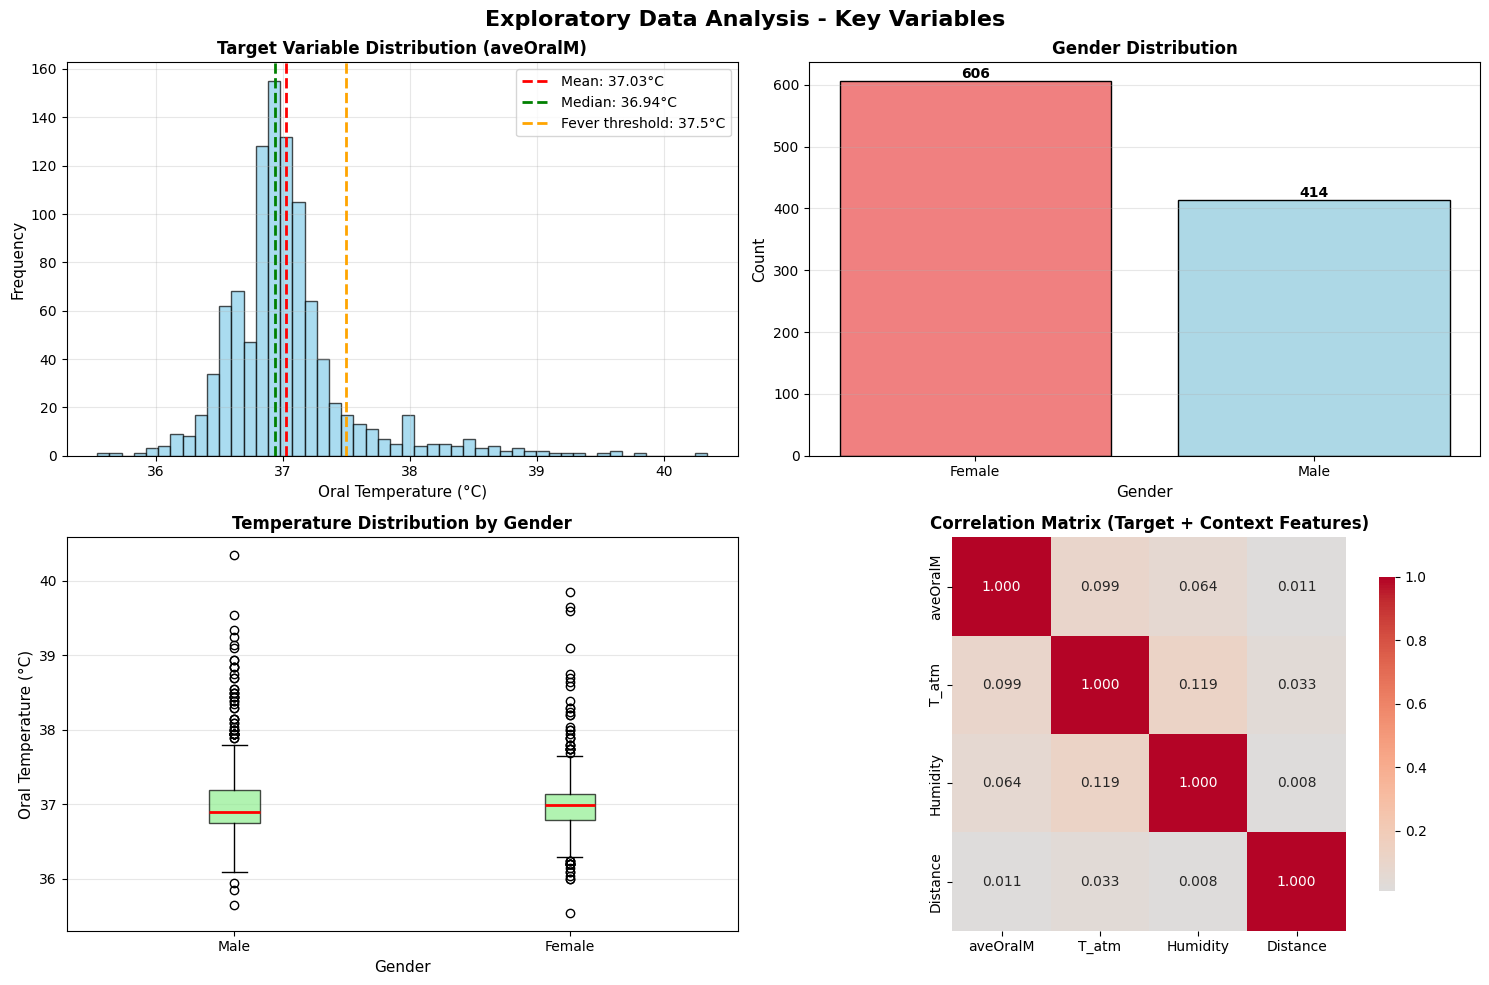

In [80]:
# Visualizations

plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Exploratory Data Analysis - Key Variables', fontsize=16, fontweight='bold')

# Target variable distribution
ax1 = axes[0, 0]
target_numeric = pd.to_numeric(df[target], errors='coerce').dropna()
ax1.hist(target_numeric, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(target_numeric.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {target_numeric.mean():.2f}°C')
ax1.axvline(target_numeric.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {target_numeric.median():.2f}°C')
ax1.axvline(37.5, color='orange', linestyle='--', linewidth=2, label='Fever threshold: 37.5°C')
ax1.set_xlabel('Oral Temperature (°C)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Target Variable Distribution (aveOralM)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Categorical features
ax2 = axes[0, 1]
if 'Gender' in df.columns:
    gender_counts = df['Gender'].value_counts()
    ax2.bar(gender_counts.index, gender_counts.values, color=['lightcoral', 'lightblue'], edgecolor='black')
    ax2.set_xlabel('Gender', fontsize=11)
    ax2.set_ylabel('Count', fontsize=11)
    ax2.set_title('Gender Distribution', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(gender_counts.values):
        ax2.text(i, v + 5, str(v), ha='center', fontweight='bold')

# Temperature by Gender - since the body temperature of men and women is often different
ax3 = axes[1, 0]
if 'Gender' in df.columns:
    temp_data = []
    labels = []
    for gender in df['Gender'].dropna().unique():
        temps = pd.to_numeric(df[df['Gender'] == gender][target], errors='coerce').dropna()
        if len(temps) > 0:
            temp_data.append(temps)
            labels.append(gender)
    
    if temp_data:
        bp = ax3.boxplot(temp_data, tick_labels=labels, patch_artist=True, 
                         boxprops=dict(facecolor='lightgreen', alpha=0.7),
                         medianprops=dict(color='red', linewidth=2))
        ax3.set_xlabel('Gender', fontsize=11)
        ax3.set_ylabel('Oral Temperature (°C)', fontsize=11)
        ax3.set_title('Temperature Distribution by Gender', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')

# Correlation with context features
ax4 = axes[1, 1]
corr_df = df[[target] + num_context].copy()
for col in [target] + num_context:
    corr_df[col] = pd.to_numeric(corr_df[col], errors='coerce')
corr_df = corr_df.dropna()

if len(corr_df) > 0:
    corr_matrix = corr_df.corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
                square=True, ax=ax4, cbar_kws={'shrink': 0.8})
    ax4.set_title('Correlation Matrix (Target + Context Features)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

The most important conclusions from the graphs above are as follows:

The target variable distribution looks normal, however the mean being higher than the median (37.03 > 36.94) indicaticates a right skewness and a long tail which can be seen. There are also meaningful outliers in the very high temperature ranges which may affect the results and warrant the need for stratification.

We can expect on average a higher temperature for females in the dataset.

The context features show low correlation with the target variable.

In [81]:
for col in numeric_features:
    X[col] = pd.to_numeric(X[col], errors="coerce")

y = pd.to_numeric(y, errors="coerce")

for col in categorical_features:
    X[col] = X[col].astype(str).replace('nan', np.nan)

ebt = (y >= 37.5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=ebt
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (816, 34) Test: (204, 34)


In [82]:
# We opted for the pipeline solution to avoid data leakage during cross validation when inputting missing data (median and most frequent may be different for each fold) 
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)


### Baseline linear regression for comparison

In [83]:
baseline_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression(n_jobs=-1)),
])

baseline_lr.fit(X_train, y_train)

pred_lr = baseline_lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
r2_lr = r2_score(y_test, pred_lr)

print("TEST MAE :", mae_lr)
print("TEST RMSE:", rmse_lr)
print("TEST R2  :", r2_lr)


TEST MAE : 0.241040605126628
TEST RMSE: 0.30594021939883875
TEST R2  : 0.697823441090547


## XGBoost

A note about the scoring method. RMSE is easy to interpret, but the most important criteria for its' selection is the context of the study. In medical enviroments big mistakes like for example predicting a normal temperature when someone in fact has a fever, are very costly so we want to limit those as much as possible.

In [84]:
model_xgb = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=random_state,
    n_jobs=-1,
    tree_method="hist", 
)

pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model_xgb", model_xgb),
])


### Randomized Search CV

In [85]:
param_distributions_xgb = {
    "model_xgb__n_estimators": [300, 500, 800],
    "model_xgb__max_depth": [2, 3, 4, 5, 6],
    "model_xgb__learning_rate": [0.01, 0.02, 0.03, 0.05, 0.07, 0.1],
    "model_xgb__subsample": [0.6, 0.7, 0.8],
    "model_xgb__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model_xgb__min_child_weight": [1, 2, 3, 5, 8, 12]
}

search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_distributions_xgb,
    n_iter=60,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=random_state,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

search_xgb


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model_xgb__colsample_bytree': [0.6, 0.7, ...], 'model_xgb__learning_rate': [0.01, 0.02, ...], 'model_xgb__max_depth': [2, 3, ...], 'model_xgb__min_child_weight': [1, 2, ...], ...}"
,n_iter,60
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [86]:
search_xgb.fit(X_train, y_train)

best_model_xgb = search_xgb.best_estimator_

# CV score 
best_cv_rmse = -search_xgb.best_score_
print("Best CV RMSE:", best_cv_rmse)
print("Best params:", search_xgb.best_params_)

# One-time test evaluation
pred = best_model_xgb.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("\nTEST MAE :", mae)
print("TEST RMSE:", rmse)
print("TEST R2  :", r2)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV RMSE: 0.2889685757161814
Best params: {'model_xgb__subsample': 0.7, 'model_xgb__n_estimators': 500, 'model_xgb__min_child_weight': 3, 'model_xgb__max_depth': 4, 'model_xgb__learning_rate': 0.01, 'model_xgb__colsample_bytree': 0.6}

TEST MAE : 0.20929251278147992
TEST RMSE: 0.27613455212109794
TEST R2  : 0.7538333993653148


Train RMSE: 0.2014
CV RMSE   : 0.2908 ± 0.0235
Test RMSE : 0.2761
-
Generalization gap (Test - Train): 0.0747  | relative: 27.05%
Generalization gap (CVmean - Train): 0.0893 | relative: 30.72%


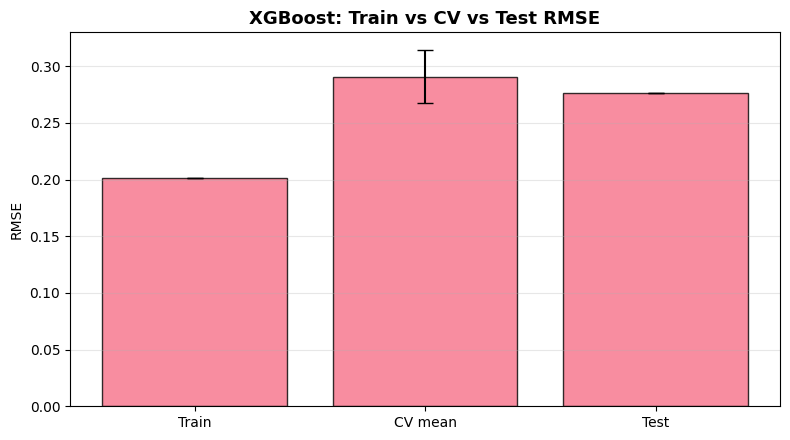

In [87]:
# XGBoost overfitting check: Train vs CV vs Test RMSE (+ relative gaps)

plt.style.use("default")
sns.set_palette("husl")

pred_train = best_model_xgb.predict(X_train)
rmse_train = float(np.sqrt(mean_squared_error(y_train, pred_train)))

pred_test = best_model_xgb.predict(X_test)
rmse_test = float(np.sqrt(mean_squared_error(y_test, pred_test)))

# CV RMSE on training set
cv_overfit = KFold(n_splits=5, shuffle=True, random_state=random_state)
cv_rmse = -cross_val_score(
    best_model_xgb,
    X_train,
    y_train,
    cv=cv_overfit,
    scoring="neg_root_mean_squared_error",
    n_jobs=1,
 )
rmse_cv_mean = float(np.mean(cv_rmse))
rmse_cv_std = float(np.std(cv_rmse))

gap_test = rmse_test - rmse_train
gap_cv = rmse_cv_mean - rmse_train

# Relative gaps: share of the evaluation RMSE explained by overfitting gap
rel_gap_test = float(gap_test / rmse_test) if rmse_test > 0 else float("nan")
rel_gap_cv = float(gap_cv / rmse_cv_mean) if rmse_cv_mean > 0 else float("nan")

print(f"Train RMSE: {rmse_train:.4f}")
print(f"CV RMSE   : {rmse_cv_mean:.4f} ± {rmse_cv_std:.4f}")
print(f"Test RMSE : {rmse_test:.4f}")
print("-")
print(f"Generalization gap (Test - Train): {gap_test:.4f}  | relative: {rel_gap_test:.2%}")
print(f"Generalization gap (CVmean - Train): {gap_cv:.4f} | relative: {rel_gap_cv:.2%}")

labels = ["Train", "CV mean", "Test"]
values = [rmse_train, rmse_cv_mean, rmse_test]
errors = [0.0, rmse_cv_std, 0.0]

plt.figure(figsize=(8, 4.5))
plt.bar(labels, values, yerr=errors, capsize=6, edgecolor="black", alpha=0.8)
plt.ylabel("RMSE")
plt.title("XGBoost: Train vs CV vs Test RMSE", fontsize=13, fontweight="bold")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

There is some concern for overfitting here, however with the noisiness of the dataset and many similar thermal columns we feel that it is on an acceptable level.

,feature,importance_mean
0,T_Max1,0.059815
1,T_OR_Max1,0.009950
2,T_FH_Max1,0.007642
3,T_atm,0.007002
4,T_OR1,0.006882
5,T_RC_Max1,0.002753
6,Gender_Female,0.002322
7,canthi4Max1,0.002204
8,T_FHLC1,0.001798
9,Age_18-20,0.001368


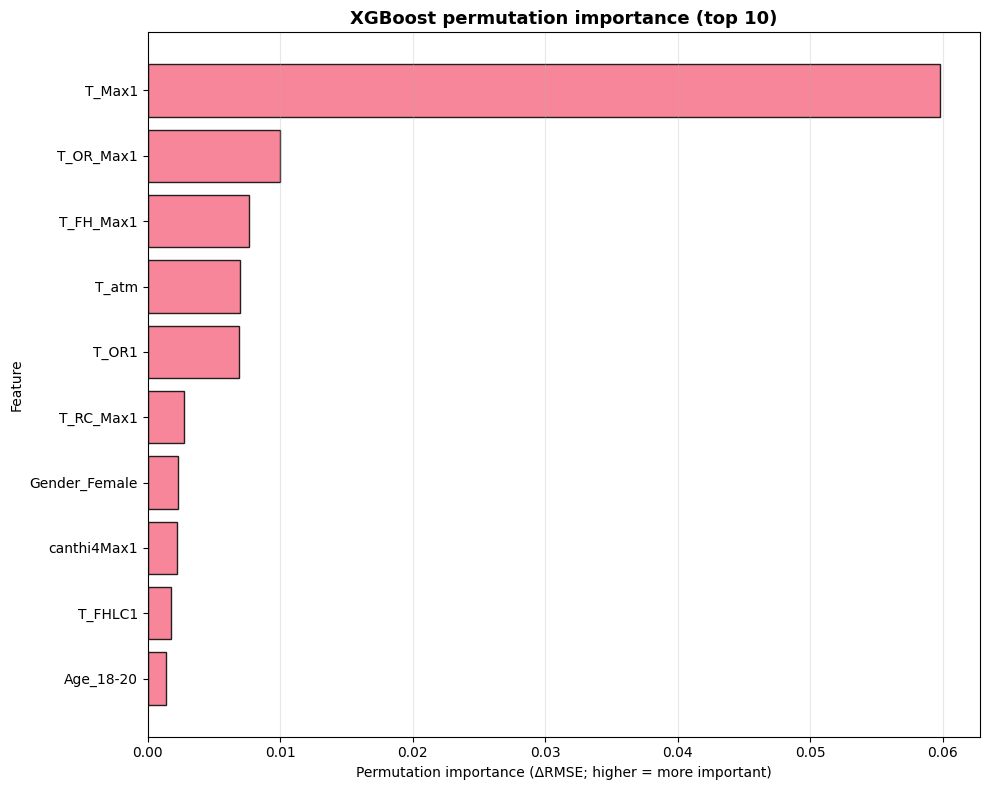

In [106]:
# Permutation importance (XGBoost) + bar chart (no std)
plt.style.use("default")
sns.set_palette("husl")

preprocess = best_model_xgb.named_steps["preprocess"]
X_test_trans = preprocess.transform(X_test)
feature_names = preprocess.get_feature_names_out()

xgb_model = best_model_xgb.named_steps["model_xgb"]

perm = permutation_importance(
    xgb_model,
    X_test_trans,
    y_test,
    scoring="neg_root_mean_squared_error",
    n_repeats=10,
    random_state=random_state,
    n_jobs=-1,
 )

fi = (pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
})
      .sort_values("importance_mean", ascending=False)
      .reset_index(drop=True))

# Table (top 25)
display(fi.head(10))

# Plot (top 25)
top_n = 10
fi_plot = fi.head(top_n).iloc[::-1]  # reverse so largest is at top on barh

plt.figure(figsize=(10, 8))
plt.barh(
    fi_plot["feature"],
    fi_plot["importance_mean"],
    edgecolor="black",
    alpha=0.85,
 )
plt.xlabel("Permutation importance (ΔRMSE; higher = more important)")
plt.ylabel("Feature")
plt.title(f"XGBoost permutation importance (top {top_n})", fontsize=13, fontweight="bold")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

Most of the categorical predictors turn out to be noise, which is not unexpected. In the context of a one time temperature measurement, the gender ,age and ethicity are overshadowed by many other factors.

## Random Forest

In [89]:
model_rf = RandomForestRegressor(
    random_state=random_state,
    n_jobs=-1,
)

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model_rf", model_rf),
])

### Randomized Search CV

In [90]:
param_distributions_rf = {
    "model_rf__n_estimators": [100,200,300],
    "model_rf__max_depth": [4, 6, 8, 12],
    "model_rf__max_features": [0.2,0.5, 0.8], 
    "model_rf__min_samples_split": randint(2, 30),
    "model_rf__min_samples_leaf": randint(1, 20),
    "model_rf__bootstrap": [True, False]
}

search_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_distributions_rf,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=random_state,
    n_jobs=-1,
    verbose=2,
)

search_rf


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model_rf__bootstrap': [True, False], 'model_rf__max_depth': [4, 6, ...], 'model_rf__max_features': [0.2, 0.5, ...], 'model_rf__min_samples_leaf': <scipy.stats....001FD287866F0>, ...}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [91]:
search_rf.fit(X_train, y_train)

best_model_rf = search_rf.best_estimator_

# CV score 
best_cv_rmse = -search_rf.best_score_
print("Best CV RMSE:", best_cv_rmse)
print("Best params:", search_rf.best_params_)

pred = best_model_rf.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("\nTEST MAE :", mae)
print("TEST RMSE:", rmse)
print("TEST R2  :", r2)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV RMSE: 0.2934944862403456
Best params: {'model_rf__bootstrap': True, 'model_rf__max_depth': 8, 'model_rf__max_features': 0.8, 'model_rf__min_samples_leaf': 4, 'model_rf__min_samples_split': 14, 'model_rf__n_estimators': 300}

TEST MAE : 0.2122828110918037
TEST RMSE: 0.2798047748527202
TEST R2  : 0.7472460993840386


Train RMSE: 0.2132
CV RMSE   : 0.2960 ± 0.0215
Test RMSE : 0.2798
-
Generalization gap (Test - Train): 0.0666  | relative: 23.81%
Generalization gap (CVmean - Train): 0.0828 | relative: 27.97%


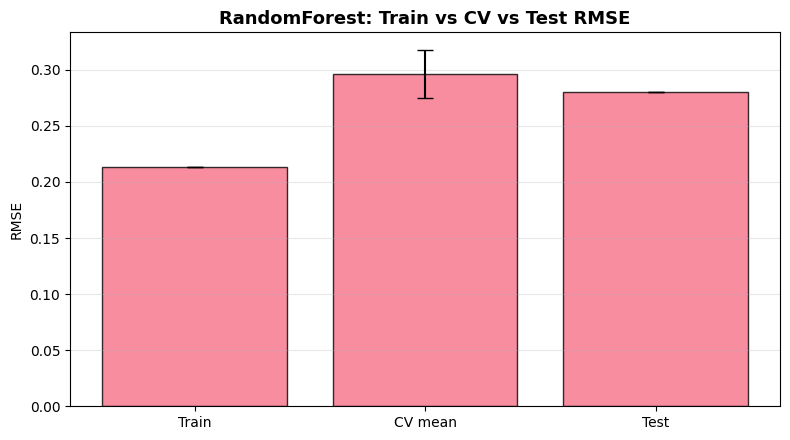

In [92]:
# RandomForest overfitting check: Train vs CV vs Test RMSE (+ relative gaps)

plt.style.use("default")
sns.set_palette("husl")

pred_train = best_model_rf.predict(X_train)
rmse_train = float(np.sqrt(mean_squared_error(y_train, pred_train)))

pred_test = best_model_rf.predict(X_test)
rmse_test = float(np.sqrt(mean_squared_error(y_test, pred_test)))

# CV RMSE on training set
cv_overfit = KFold(n_splits=5, shuffle=True, random_state=random_state)
cv_rmse = -cross_val_score(
    best_model_rf,
    X_train,
    y_train,
    cv=cv_overfit,
    scoring="neg_root_mean_squared_error",
    n_jobs=1,
 )
rmse_cv_mean = float(np.mean(cv_rmse))
rmse_cv_std = float(np.std(cv_rmse))

gap_test = rmse_test - rmse_train
gap_cv = rmse_cv_mean - rmse_train
rel_gap_test = float(gap_test / rmse_test) if rmse_test > 0 else float("nan")
rel_gap_cv = float(gap_cv / rmse_cv_mean) if rmse_cv_mean > 0 else float("nan")

print(f"Train RMSE: {rmse_train:.4f}")
print(f"CV RMSE   : {rmse_cv_mean:.4f} ± {rmse_cv_std:.4f}")
print(f"Test RMSE : {rmse_test:.4f}")
print("-")
print(f"Generalization gap (Test - Train): {gap_test:.4f}  | relative: {rel_gap_test:.2%}")
print(f"Generalization gap (CVmean - Train): {gap_cv:.4f} | relative: {rel_gap_cv:.2%}")

labels = ["Train", "CV mean", "Test"]
values = [rmse_train, rmse_cv_mean, rmse_test]
errors = [0.0, rmse_cv_std, 0.0]

plt.figure(figsize=(8, 4.5))
plt.bar(labels, values, yerr=errors, capsize=6, edgecolor="black", alpha=0.8)
plt.ylabel("RMSE")
plt.title("RandomForest: Train vs CV vs Test RMSE", fontsize=13, fontweight="bold")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

,feature,importance_mean
0,T_Max1,0.090480
1,T_FH_Max1,0.012546
2,T_RC_Max1,0.007099
3,canthi4Max1,0.005062
4,T_OR_Max1,0.004581
5,T_OR1,0.004543
6,T_atm,0.002674
7,T_RC1,0.001846
8,Gender_Male,0.001581
9,Gender_Female,0.001467


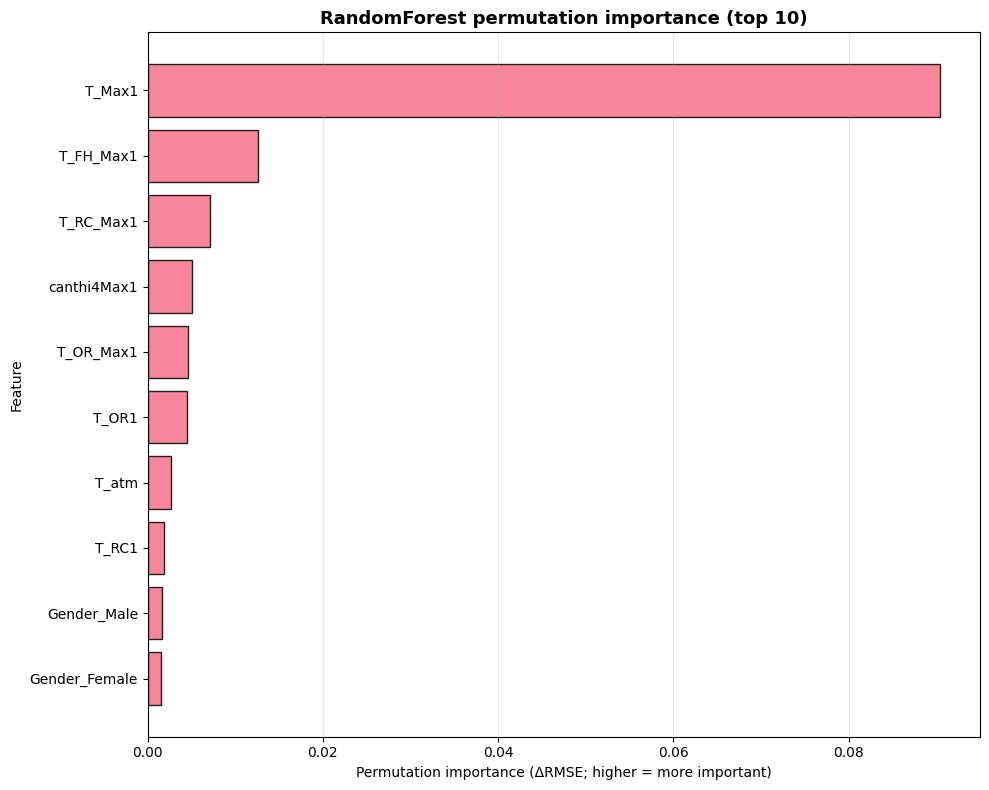

In [107]:
# Permutation importance (RandomForest) + bar chart (no std)
plt.style.use("default")
sns.set_palette("husl")

preprocess = best_model_rf.named_steps["preprocess"]
X_test_trans = preprocess.transform(X_test)
feature_names = preprocess.get_feature_names_out()

rf_model = best_model_rf.named_steps["model_rf"]

perm = permutation_importance(
    rf_model,
    X_test_trans,
    y_test,
    scoring="neg_root_mean_squared_error",
    n_repeats=10,
    random_state=random_state,
    n_jobs=-1,
 )

fi = (pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
})
      .sort_values("importance_mean", ascending=False)
      .reset_index(drop=True))

# Table (top 10)
display(fi.head(10))

# Plot (top 10)
top_n = 10
fi_plot = fi.head(top_n).iloc[::-1]

plt.figure(figsize=(10, 8))
plt.barh(
    fi_plot["feature"],
    fi_plot["importance_mean"],
    edgecolor="black",
    alpha=0.85,
 )
plt.xlabel("Permutation importance (ΔRMSE; higher = more important)")
plt.ylabel("Feature")
plt.title(f"RandomForest permutation importance (top {top_n})", fontsize=13, fontweight="bold")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

## Neural Network

In [94]:
numeric_transformer_mlp = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor_mlp = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_mlp, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

mlp = MLPRegressor(
    random_state=random_state,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    max_iter=1000
)
# The max iterations are set quite high but since we are using early stopping it should not cause any problems, the other thing to mention is that only for
# the neural network we are scaling the target variable to help with convergence.
pipe = Pipeline(steps=[
    ("preprocess", preprocessor_mlp),
    ("model", mlp),
])

reg = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())

In [95]:
architectures = [
    (32,),
    (64,),
    (128,),
    (64,64),
    (128, 64)
]

param_distributions_mlp = {
    "regressor__model__hidden_layer_sizes": architectures,
    "regressor__model__activation": ["relu"],
    "regressor__model__alpha": np.logspace(-6, -2, 30),          # L2 regularization strength
    "regressor__model__learning_rate_init": np.logspace(-5, -3, 25),
    "regressor__model__batch_size": [32, 64, 128, 256],
    "regressor__model__beta_1": [0.9, 0.95],
    "regressor__model__beta_2": [0.999, 0.995],
}

cv_mlp = KFold(n_splits=5, shuffle=True, random_state=random_state)

search_mlp = RandomizedSearchCV(
    estimator=reg,
    param_distributions=param_distributions_mlp,
    n_iter=60,
    scoring="neg_root_mean_squared_error",
    cv=cv_mlp,
    random_state=random_state,
    n_jobs=1,
    verbose=1,
)

search_mlp


,estimator,TransformedTa...ndardScaler())
,param_distributions,"{'regressor__model__activation': ['relu'], 'regressor__model__alpha': array([1.0000...00000000e-02]), 'regressor__model__batch_size': [32, 64, ...], 'regressor__model__beta_1': [0.9, 0.95], ...}"
,n_iter,60
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [96]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

search_mlp.fit(X_train, y_train)

best_model_mlp = search_mlp.best_estimator_
mlp_fitted = best_model_mlp.regressor_.named_steps["model"]

# CV score
best_cv_rmse = -search_mlp.best_score_
print(f"Best CV RMSE: {best_cv_rmse:.4f}")
print(f"\nBest params: {search_mlp.best_params_}")

pred = best_model_mlp.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"TEST MAE : {mae:.4f}")
print(f"TEST RMSE: {rmse:.4f}")
print(f"TEST R²  : {r2:.4f}")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV RMSE: 0.2953

Best params: {'regressor__model__learning_rate_init': np.float64(0.00038311868495572853), 'regressor__model__hidden_layer_sizes': (128,), 'regressor__model__beta_2': 0.995, 'regressor__model__beta_1': 0.9, 'regressor__model__batch_size': 128, 'regressor__model__alpha': np.float64(0.0003039195382313198), 'regressor__model__activation': 'relu'}
TEST MAE : 0.2113
TEST RMSE: 0.2721
TEST R²  : 0.7609


Train RMSE: 0.2604
CV RMSE   : 0.2953 ± 0.0270
Test RMSE : 0.2721
-
Generalization gap (Test - Train): 0.0117  | relative: 4.31%
Generalization gap (CVmean - Train): 0.0349 | relative: 11.80%


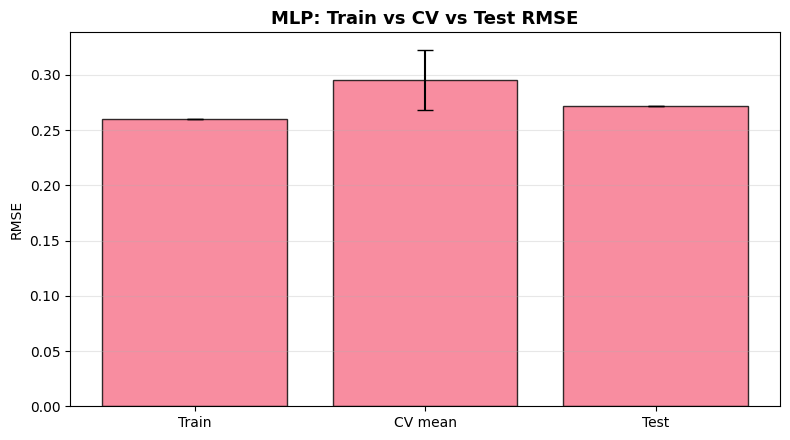

In [97]:
# Neural Network (MLP) overfitting check: Train vs CV vs Test RMSE (+ relative gaps)
plt.style.use("default")
sns.set_palette("husl")

pred_train = best_model_mlp.predict(X_train)
rmse_train = float(np.sqrt(mean_squared_error(y_train, pred_train)))

pred_test = best_model_mlp.predict(X_test)
rmse_test = float(np.sqrt(mean_squared_error(y_test, pred_test)))

# CV RMSE on training set
cv_overfit = KFold(n_splits=5, shuffle=True, random_state=random_state)
cv_rmse = -cross_val_score(
    best_model_mlp,
    X_train,
    y_train,
    cv=cv_overfit,
    scoring="neg_root_mean_squared_error",
    n_jobs=1,
 )
rmse_cv_mean = float(np.mean(cv_rmse))
rmse_cv_std = float(np.std(cv_rmse))

gap_test = rmse_test - rmse_train
gap_cv = rmse_cv_mean - rmse_train
rel_gap_test = float(gap_test / rmse_test) if rmse_test > 0 else float("nan")
rel_gap_cv = float(gap_cv / rmse_cv_mean) if rmse_cv_mean > 0 else float("nan")

print(f"Train RMSE: {rmse_train:.4f}")
print(f"CV RMSE   : {rmse_cv_mean:.4f} ± {rmse_cv_std:.4f}")
print(f"Test RMSE : {rmse_test:.4f}")
print("-")
print(f"Generalization gap (Test - Train): {gap_test:.4f}  | relative: {rel_gap_test:.2%}")
print(f"Generalization gap (CVmean - Train): {gap_cv:.4f} | relative: {rel_gap_cv:.2%}")

labels = ["Train", "CV mean", "Test"]
values = [rmse_train, rmse_cv_mean, rmse_test]
errors = [0.0, rmse_cv_std, 0.0]

plt.figure(figsize=(8, 4.5))
plt.bar(labels, values, yerr=errors, capsize=6, edgecolor="black", alpha=0.8)
plt.ylabel("RMSE")
plt.title("MLP: Train vs CV vs Test RMSE", fontsize=13, fontweight="bold")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [98]:
# This was mostly done from curiosity, to see what kind of network architectures do well in this scenacrio. It seems that in general with the smaller sample size
# the networks with one hidden layer do better, possibly because they are less prone to overfitting.
cv_results = pd.DataFrame(search_mlp.cv_results_)

cv_results['mean_rmse'] = -cv_results['mean_test_score']
cv_results['std_rmse'] = cv_results['std_test_score'].abs()

param_cols = [col for col in cv_results.columns if col.startswith('param_')]
result_cols = param_cols + ['mean_rmse', 'std_rmse', 'rank_test_score']


cv_results_sorted = cv_results[result_cols].sort_values('mean_rmse')

print("="*80)
print("BEST 10 PARAMETER COMBINATIONS (Lowest RMSE)")
print("="*80)
print(cv_results_sorted.head(10).to_string(index=False))

print("\n" + "="*80)
print("WORST 10 PARAMETER COMBINATIONS (Highest RMSE)")
print("="*80)
print(cv_results_sorted.tail(10).to_string(index=False))


BEST 10 PARAMETER COMBINATIONS (Lowest RMSE)
 param_regressor__model__learning_rate_init param_regressor__model__hidden_layer_sizes  param_regressor__model__beta_2  param_regressor__model__beta_1  param_regressor__model__batch_size  param_regressor__model__alpha param_regressor__model__activation  mean_rmse  std_rmse  rank_test_score
                                   0.000383                                     (128,)                           0.995                            0.90                                 128                       0.000304                               relu   0.295264  0.027040                1
                                   0.000825                                      (32,)                           0.999                            0.90                                  32                       0.000013                               relu   0.301370  0.024695                2
                                   0.000825                                     (1

Iterations actually run: 61
Final loss: 0.12249036933228469


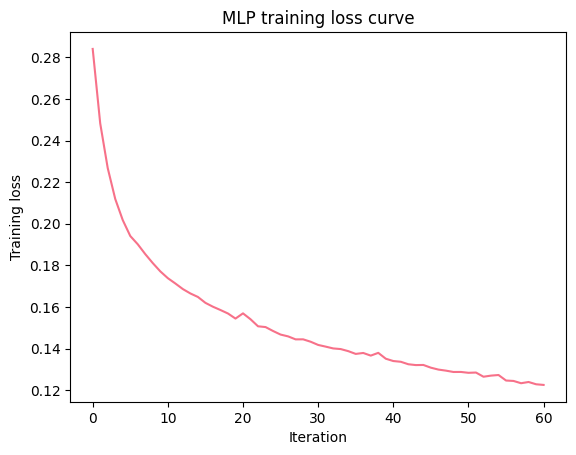

In [99]:
# Training loss curve for Neural Network
mlp_fitted = best_model_mlp.regressor_.named_steps["model"]

print("Iterations actually run:", getattr(mlp_fitted, "n_iter_", None))
print("Final loss:", mlp_fitted.loss_)

plt.figure()
plt.plot(mlp_fitted.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.title("MLP training loss curve")
plt.show()


In [100]:
# A quick stability check using shuffled K-Fold CV on the training set with the best MLP model
cv_shuf = KFold(n_splits=5, shuffle=True, random_state=random_state)
rmse_scores = -cross_val_score(best_model_mlp, X_train, y_train, cv=cv_shuf, scoring='neg_root_mean_squared_error', n_jobs=1)
print('Shuffled-fold RMSEs:', np.array2string(rmse_scores, precision=4))
print('Mean RMSE:', float(rmse_scores.mean()), 'Std:', float(rmse_scores.std()))


Shuffled-fold RMSEs: [0.3164 0.2836 0.309  0.3198 0.2475]
Mean RMSE: 0.29526397239509117 Std: 0.02703996262949595


## Final comparison

In [101]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv):
    from sklearn.base import clone
    # CV metrics
    cv_rmse = -cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=1,
    )
    cv_rmse_mean = float(np.mean(cv_rmse))
    cv_rmse_std = float(np.std(cv_rmse))
    
    # Fit once on full training set for train/test metrics
    fitted = clone(model)
    fitted.fit(X_train, y_train)
    pred_train = fitted.predict(X_train)
    pred_test = fitted.predict(X_test)
    
    train_rmse = float(np.sqrt(mean_squared_error(y_train, pred_train)))
    test_rmse = float(np.sqrt(mean_squared_error(y_test, pred_test)))
    
    gap_test = float(test_rmse - train_rmse)
    gap_cv = float(cv_rmse_mean - train_rmse)
    rel_gap_test = float(gap_test / test_rmse) if test_rmse > 0 else float("nan")
    rel_gap_cv = float(gap_cv / cv_rmse_mean) if cv_rmse_mean > 0 else float("nan")
    
    return {
        "model": name,
        "cv_rmse_mean": cv_rmse_mean,
        "cv_rmse_std": cv_rmse_std,
        "train_rmse": train_rmse,
        "test_mae": float(mean_absolute_error(y_test, pred_test)),
        "test_rmse": test_rmse,
        "test_r2": float(r2_score(y_test, pred_test)),
        "gap_test": gap_test,
        "rel_gap_test": rel_gap_test,
        "gap_cv": gap_cv,
        "rel_gap_cv": rel_gap_cv,
    }

cv_compare = KFold(n_splits=5, shuffle=True, random_state=random_state)

models_to_compare = {
    "LinearRegression (baseline)": baseline_lr,
    "XGBoost (tuned)": best_model_xgb,
    "RandomForest (tuned)": best_model_rf,
    "MLP (tuned)": best_model_mlp,
}

rows = [
    evaluate_model(name, model, X_train, y_train, X_test, y_test, cv_compare)
    for name, model in models_to_compare.items()
 ]

compare_df = pd.DataFrame(rows).sort_values("test_rmse").reset_index(drop=True)
compare_df

,model,cv_rmse_mean,cv_rmse_std,train_rmse,test_mae,test_rmse,test_r2,gap_test,rel_gap_test,gap_cv,rel_gap_cv
0,MLP (tuned),0.295264,0.027040,0.260414,0.211304,0.272148,0.760891,0.011734,0.043115,0.034850,0.118030
1,XGBoost (tuned),0.290753,0.023480,0.201440,0.209293,0.276135,0.753833,0.074695,0.270501,0.089313,0.307179
2,RandomForest (tuned),0.295965,0.021497,0.213176,0.212283,0.279805,0.747246,0.066629,0.238126,0.082789,0.279726
3,LinearRegression (baseline),0.327963,0.028691,0.296414,0.241041,0.305940,0.697823,0.009526,0.031138,0.031550,0.096198


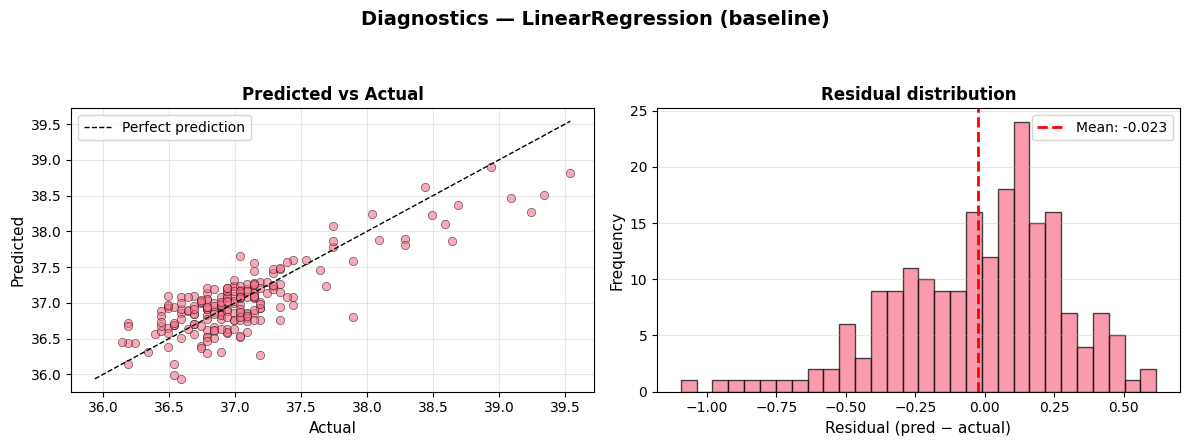

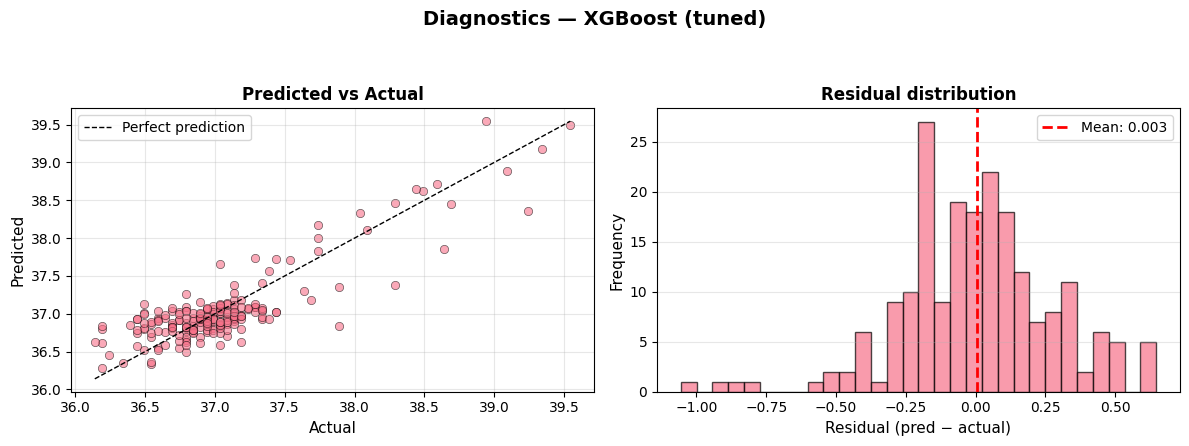

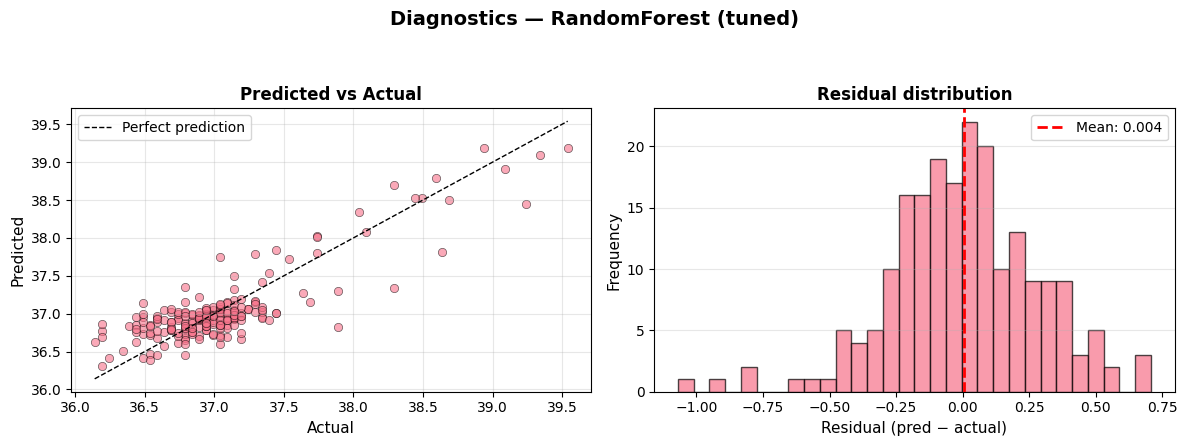

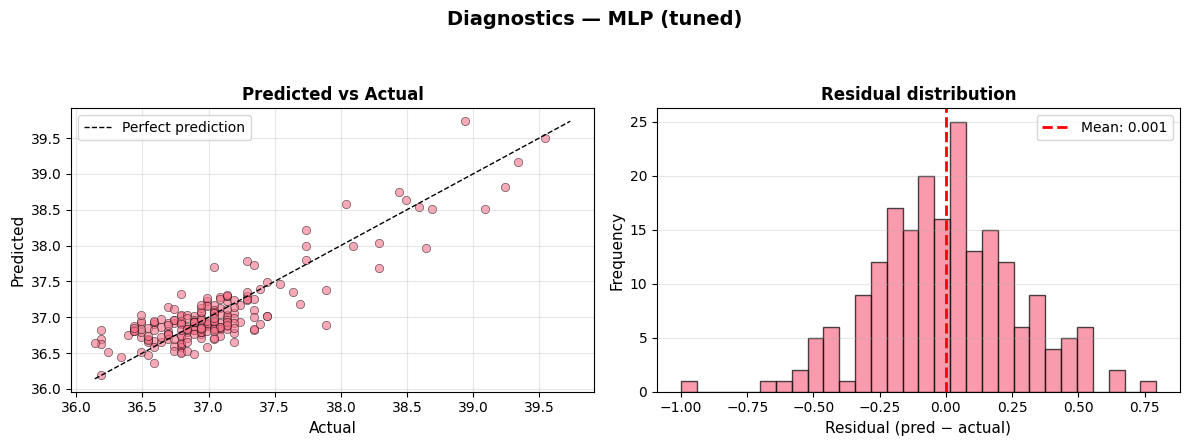

In [102]:
plt.style.use("default")
sns.set_palette("husl")

models_diag = {
    "LinearRegression (baseline)": baseline_lr,
    "XGBoost (tuned)": best_model_xgb,
    "RandomForest (tuned)": best_model_rf,
    "MLP (tuned)": best_model_mlp,
}

rows = []
for name, model in models_diag.items():
    pred_test = model.predict(X_test)
    residuals = pred_test - y_test.to_numpy()

    rows.append({
        "model": name,
        "test_mae": float(mean_absolute_error(y_test, pred_test)),
        "test_rmse": float(np.sqrt(mean_squared_error(y_test, pred_test))),
        "test_r2": float(r2_score(y_test, pred_test)),
        "bias_mean(resid)": float(np.mean(residuals)),
    })

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    fig.suptitle(f"Diagnostics — {name}", fontsize=14, fontweight="bold")

    # Predicted vs Actual
    ax = axes[0]
    ax.scatter(
        y_test,
        pred_test,
        alpha=0.6,
        edgecolors="k",
        linewidth=0.5,
    )
    lo = float(min(y_test.min(), np.min(pred_test)))
    hi = float(max(y_test.max(), np.max(pred_test)))
    ax.plot([lo, hi], [lo, hi], "k--", linewidth=1, label="Perfect prediction")
    ax.set_xlabel("Actual", fontsize=11)
    ax.set_ylabel("Predicted", fontsize=11)
    ax.set_title("Predicted vs Actual", fontsize=12, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Residuals
    ax = axes[1]
    ax.hist(residuals, bins=30, edgecolor="black", alpha=0.7)
    ax.axvline(
        np.mean(residuals),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {np.mean(residuals):.3f}",
    )
    ax.set_xlabel("Residual (pred − actual)", fontsize=11)
    ax.set_ylabel("Frequency", fontsize=11)
    ax.set_title("Residual distribution", fontsize=12, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")

    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()